# Librairies

In [274]:
import glob
from pathlib import Path
import os
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image, ImageMath

import math

import warnings
import logging

from keras.layers import Input, Dense, Conv1D, Conv2D, concatenate, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.regularizers import l1 
    
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MinMaxScaler

from numpy.random import seed
seed(1)


print(keras.__version__)
print(pd.__version__)

2.4.3
1.0.5


# Parameters

In [503]:
#Grid size + response variable 
gridSize=100
provider="Mapbox"
verbose = False
resp="v_CA16_406" #v_CA16_2540:poverty -- v_CA16_406:pop_density per sq km
finalNonLin = "sigmoid" if resp == "v_CA16_2540" else "relu" #final non-linearity: sigmoid to predict [0,1] normalized value vs relu otherwise (since response is non-negative)
idGrid="gridId"
ubNumTotal = 3*10**3 #use this upper bound, otherwise it is impossible to load all images into anarray => should most likey think of some better data pipeline where we load batches of images eachtimeS
propVal = 0.15 #proportion of train used for validation

In [23]:
rootDir='/home/charles/Projects/NeuralNetPopulation'

In [24]:
#Path to out put figures
figuresOutputPath = Path(rootDir) / "Figures" / provider / str(gridSize )

if not os.path.exists(figuresOutputPath):
    print(f"Creating directory {figuresOutputPath}")
    os.makedirs(figuresOutputPath)
else:
    print(f"Directory {figuresOutputPath} already exists")

Directory /home/charles/Projects/NeuralNetPopulation/Figures/Mapbox/100 already exists


In [25]:
#Path to output tmp models
modelsOutputPath = Path("." ) / ".." / ".." / "Data" / "Models" / provider / str(gridSize )

if not os.path.exists(modelsOutputPath):
    print(f"Creating directory {modelsOutputPath}")
    os.makedirs(modelsOutputPath)
else:
    print(f"Directory {modelsOutputPath} already exists")

Directory ../../Data/Models/Mapbox/100 already exists


In [26]:
#Path to save the history as a csv
historyOutputPath = Path("." ) / ".." /  ".." / "Data" / "History" / provider / str(gridSize )

if not os.path.exists(historyOutputPath):
    print(f"Creating directory {historyOutputPath}")
    os.makedirs(historyOutputPath)
else:
    print(f"Directory {historyOutputPath} already exists")

Directory ../../Data/History/Mapbox/100 already exists


In [27]:
#Path to census shp file
shpFilePath = Path(".") / ".." /  ".." /  "Data" / "GeoData" / "Shp" / "shpCensusMtl.shp"

In [28]:
#Parameters for conv net
lr = 5*10**-4
numEpochs=20 # 
batchSize=2**5 #32

l1Coeff = 0 #10**-3
dropoutRate=0.1 #0.6

ConvNetClass = VGG19
convNetName = "Vgg19"

verbose=True

In [29]:
# model name
mdlId = f"{provider}_{resp}_{convNetName}_gridSize_{gridSize}_lr_{lr}_batchSize_{batchSize}_numEpochs_{numEpochs}_l1Coeff_{l1Coeff}_dropoutRate_{dropoutRate}"
mdlId

'Mapbox_v_CA16_406_Vgg19_gridSize_100_lr_0.0005_batchSize_32_numEpochs_20_l1Coeff_0_dropoutRate_0.1'

In [30]:
#Logger 
logBasePath=Path("." ) / ".." / ".." / "Log"
logger = logging.getLogger('convNetPred')
hdlr = logging.FileHandler(logBasePath / f"log_{date.today()}_{mdlId}.txt")
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

logger.addHandler(hdlr)
logger.warning(f"{date.today()}")

# Data input

In [31]:
pathPng=Path(".") / ".." /  ".." /"Output" / str(provider) / str(gridSize) / "Images"
pathCsv = Path(".") / ".." /  ".." /"Output" / str(provider) / str(gridSize) / "Csv"
listPngs= np.unique([ f for f in pathPng.glob("*.png")] ) # watch out for possible duplicates
mdlId=f"{mdlId}_numImgs_{len(listPngs)}"
print(len(listPngs))

4104


(480, 480, 3)

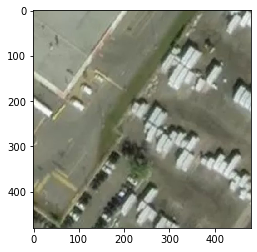

In [32]:
#Quick test
im=Image.open(listPngs[1]).convert('RGB')
plt.imshow(im)
np.array(im).shape

In [97]:
dfGrid=pd.read_csv(pathCsv / "dfGrid.csv")
dfGrid.drop_duplicates(idGrid, inplace=True) #remove duplicate images
dfGrid['pathImg'] = [ str(Path(pathPng) / f"{r}.png") for r in dfGrid[idGrid]]
print(dfGrid.shape)
dfGrid.head()

(3488, 12)


Group.1   v_CA16_2213  v_CA16_2540    v_CA16_406      gridId    GeoUID  \
0        1  22503.158417    28.333734  12839.862050   1ahuntsic  24660517   
1        2  23329.019053    18.844351   9601.852952   2ahuntsic  24660513   
2       11           NaN          NaN      0.000000  11ahuntsic  24663351   
3       12           NaN          NaN    201.064136  12ahuntsic  24663351   
4       13           NaN          NaN    722.660359  13ahuntsic  24663351   

                 Q_socio                   neighTouching  numberNeigh  \
0  Bordeaux-Cartierville           Bordeaux-Cartierville          1.0   
1  Bordeaux-Cartierville           Bordeaux-Cartierville          1.0   
2  Bordeaux-Cartierville           Bordeaux-Cartierville          1.0   
3  Bordeaux-Cartierville  Ahuntsic,Bordeaux-Cartierville          2.0   
4  Bordeaux-Cartierville  Ahuntsic,Bordeaux-Cartierville          2.0   

   numberDA    rastID                                        pathImg  
0       4.0  ahuntsic   ../../Output/Mapbox/100/Images/1ahuntsic.png  
1       5.0  ahuntsic   ../../Output/Mapbox/100/Images/2ahuntsic.png  
2       1.0  ahuntsic  ../../Output/Mapbox/100/Images/11ahuntsic.png  
3       2.0  ahuntsic  ../../Output/Mapbox/100/Images/12ahuntsic.png  
4       2.0  ahuntsic  ../../Output/Mapbox/100/Images/13ahuntsic.png

# Train test holdout split

In [61]:
listPngs=listPngs[:10] #Watch out! large number of pictures

numTotal = min(ubNumTotal, len(listPngs))
numTrain= math.floor(numTotal*0.8) 
numTest= numTotal - numTrain
numTotal, numTrain, numTest


(10, 8, 2)

In [62]:
def getIdxNoImg(sliceIdx, idGrid, resp):
    ''' Get the valid indices given a slice 
    
    params:
        sliceIdx : slide t
        idGrid: str indicating the index of each records in dfGrid
        resp: str indicating response variable
    returns:
        tuple of (np.array of indices, np.arrray of iamges - which all have the same shape)
    '''
    
    idxList=[]
    listIm=[]
    for  f in listPngs[sliceIdx] :

        #Read the image
        im= Image.open(f)
        
        if im.mode != "RGB":
            im = im.convert("RGB")
            
        #Convert to array
        array=np.array(im)
        picId = (f.stem)
        picIdx=np.where( dfGrid[idGrid] == picId )[0]
        if len(picIdx) > 1 :
            raise Exception(f"Fatal error! picture {picId} appears more than once ({len(picIdx)} times) in the grid shp (0 times is possible)")
        
        im.close()
        
        #Get the response 
        dfFiltered = dfGrid.loc[ dfGrid[idGrid] == picId, resp]
        nrow = dfFiltered.shape[0]
        
        #Make sure we have all 3 rgb channels + the response is correct
        if nrow == 1 and len(array.shape) == 3 and ~np.all(np.isnan(dfFiltered)) :
            idxList.append(picIdx)
            listIm.append(array)
        else:
            srtrDim = ",".join( [str(s) for s in array.shape] )
            logger.warning(f"Skipping file {f.stem} - the dimensions do not match {srtrDim} - number of matches :{nrow} - resp is nan? {dfFiltered}")

        
                
    return np.array(idxList).astype(int)

In [512]:
idxTrain= getIdxNoImg( slice(0,numTrain) , idGrid, resp)
idxTest= getIdxNoImg( slice(numTrain,numTotal), idGrid, resp)

#Get the dimension (fixed) for all images
imRep = Image.open( dfGrid.loc[idxTrain[0], "pathImg"].values[0] )
repDim= np.array(imRep).shape

#Quite a bit of errors - missing reponse or error with png images
repDim, idxTrain[:4], idxTest[:4] 

((480, 480, 3),
 array([[141],
        [350],
        [485],
        [642]]),
 array([[1310],
        [1140]]))

In [514]:
#Now the validation test from the train
np.random.shuffle(idxTrain)
numValid=int(np.ceil(propVal*len(idxTrain)))
idxValid = idxTrain[:numValid]
idxTrain = idxTrain[ ~np.isin(idxTrain,idxValid) ]

if len(idxValid) <= 0 or len(idxTrain) <=0 : 
    raise Exception("Fatal error! need at least 1 bservation for both the train and test sets")
    
idxTrain, idxValid

(array([485, 642, 814, 141, 350]), array([999]))

In [515]:
#Quick validation: test and train sets must be disjoint  3! = 6 different checks
assert( ~np.any(np.isin( idxTrain , idxTest)))
assert( ~np.any(np.isin( idxTrain , idxValid)))

assert( ~np.any(np.isin( idxTest  , idxTrain)))
assert( ~np.any(np.isin( idxTest  , idxValid)))

assert( ~np.any(np.isin( idxValid , idxTrain)))
assert( ~np.any(np.isin( idxValid , idxTest))) 

# Data generator (from correct labels and data)

In [545]:
class customDataGenerator(keras.utils.Sequence):
    """ Read images from disk on the fly
    Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
      
    """  
    def __init__(self, dfGrid, indices, dim, batch_size,scaler,shuffle=True):
        
        self.dfGrid = dfGrid
        self.dim= dim
        self.batch_size= min(len(indices), batch_size)
        if self.batch_size == len(indices):
            print(f"The number of indices must be at least as large as the batch size! {len(indices)}")
        
        self.scaler = scaler
        self.shuffle = shuffle
        self.indices = indices
        
        if self.shuffle :
            np.random.shuffle(self.indices) #works in place
         
            
    def __len__(self):
        return int(np.floor(len(self.indices)/self.batch_size))
    
    
    
    def __getitem__(self,index):
        
        if self.batch_size*index >= len(self.indices):
            raise Exception(f"Array dimension error! can only consider index of up to {self.__len__()}")
        
        indices = self.indices [ index * self.batch_size:(index+1)*self.batch_size]
        
        
        X, y = self.__data_generation(indices)
        
        return X,y
    
 
            
    def __data_generation(self,indices):
        
        X = np.concatenate( [self.readImgAsArray(p) for p in self.dfGrid.loc[indices, 'pathImg'] ] )
        y = self.scaler.transform( dfGrid.loc[indices, resp ].values.reshape(-1,1) )
        print(y)
                                
        return X, y
        
        
    def readImgAsArray(self, path):
        
        im =Image.open(path)
        
        return np.expand_dims( np.array(im)/255., 0)

In [546]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dfGrid, list_IDs, labels, 
                 batch_size=32, dim=(32,32,32),  shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.dfGrid=dfGrid

        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.array(Image.open(self.dfGrid.loc[i, 'pathImg']))

            # Store class
            y[i] = self.labels[ID]

        return X, y

## Min max scaler

In [516]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit_transform(yTrain), minMaxScaler.fit_transform(dfGrid.loc[:,resp].values.reshape(-1,1)) #reshape to column vector

(array([[0.00641849],
        [0.16708443],
        [0.44351045],
        [1.        ],
        [0.32301565],
        [0.        ]]),
 array([[0.33382017],
        [0.24963603],
        [0.        ],
        ...,
        [0.336378  ],
        [0.35942007],
        [0.34487831]]))

In [517]:
minMaxScaler.data_max_

array([38463.41030758])

## Large batch size => returns all data

In [548]:
myGenTrain = customDataGenerator(dfGrid = dfGrid,
                                 indices= idxTrain, 
                                 dim=repDim, 
                                 batch_size=batchSize,
                                scaler=minMaxScaler)

The number of indices must be at least as large as the batch size! 5


## Smaller batch size => can return multiple slices

In [549]:
myGenTrain2 = customDataGenerator(dfGrid = dfGrid,
                                 indices= idxTrain, 
                                 dim=repDim, 
                                 batch_size=2,
                                  scaler=minMaxScaler)

myGenTrain22 = customDataGenerator(dfGrid = dfGrid,
                                 indices= idxTrain, 
                                 dim=repDim, 
                                 batch_size=2,
                                  scaler=minMaxScaler)

myGenTrain23 = customDataGenerator(dfGrid = dfGrid,
                                 indices= idxTrain, 
                                 dim=repDim, 
                                 batch_size=2,
                                  scaler=minMaxScaler)

len(myGenTrain2)

2

In [550]:
myGenValid2 = customDataGenerator(dfGrid = dfGrid,
                                 indices= idxValid, 
                                 dim=repDim, 
                                 batch_size=2,
                                  scaler=minMaxScaler)

len(myGenValid2)

The number of indices must be at least as large as the batch size! 1


1

In [551]:
myGenTest2 = customDataGenerator(dfGrid = dfGrid,
                                 indices= idxTest, 
                                 dim=repDim, 
                                 batch_size=len(idxTest),
                                  scaler=minMaxScaler)

len(myGenTest2)

The number of indices must be at least as large as the batch size! 2


1

## Default generator from web as benchmark

In [552]:
# Parameters
params = {'dim': (480,480,3),
          'batch_size': 2,
          'shuffle': True}

training_generator = DataGenerator(dfGrid, idxTrain, dfGrid.loc[ idxTrain,resp], **params)

training_generator2 = DataGenerator(dfGrid, idxTrain, dfGrid.loc[ idxTrain,resp], **params) #randomization test

### Test batch size

In [553]:
len(myGenTrain), len(myGenTrain2), len(training_generator)

(1, 2, 2)

In [554]:
X,y=myGenTrain[0] 
X.shape, y.shape, repDim

[[0.14467888]
 [0.24286978]
 [0.44054368]
 [0.0876078 ]
 [0.20006812]]


((5, 480, 480, 3), (5, 1), (480, 480, 3))

In [555]:
X,y=myGenTrain2[0]
X.shape, y.shape, repDim, y  

[[0.14467888]
 [0.24286978]]


((2, 480, 480, 3),
 (2, 1),
 (480, 480, 3),
 array([[0.14467888],
        [0.24286978]]))

In [556]:
X,y=myGenTrain2[1]
X.shape, y.shape, repDim, y  

[[0.44054368]
 [0.0876078 ]]


((2, 480, 480, 3),
 (2, 1),
 (480, 480, 3),
 array([[0.44054368],
        [0.0876078 ]]))

### Test randomization

In [557]:
X,y=myGenTrain2[0]
y

[[0.14467888]
 [0.24286978]]


array([[0.14467888],
       [0.24286978]])

In [558]:
X,y=myGenTrain2[1]
y

[[0.44054368]
 [0.0876078 ]]


array([[0.44054368],
       [0.0876078 ]])

In [559]:
X,y=myGenTrain22[0]
y

[[0.14467888]
 [0.24286978]]


array([[0.14467888],
       [0.24286978]])

In [560]:
X,y=myGenTrain22[1]
y

[[0.44054368]
 [0.0876078 ]]


array([[0.44054368],
       [0.0876078 ]])

In [561]:
X,y=myGenTrain23[0]
y

[[0.14467888]
 [0.24286978]]


array([[0.14467888],
       [0.24286978]])

In [562]:
X,y=myGenTrain23[1]
y

[[0.44054368]
 [0.0876078 ]]


array([[0.44054368],
       [0.0876078 ]])

In [563]:
X,y=training_generator[0]
X.shape, y.shape, repDim, y  

((2, 480, 480, 3), (2,), (480, 480, 3), array([16944,  7695]))

# Simple conv model to test out on small dataset

In [564]:
inputLyr= Input(shape=(  repDim ),name="input")
conv=Conv2D( 2**2, (13,13), strides=(5,5), padding="valid" , name="conv1")(inputLyr)
flat=Flatten()(conv)
finalOutput = Dense( 1, activation = 'linear')(flat)

In [565]:
mdl= Model(inputLyr, finalOutput )
mdl.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 480, 480, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 94, 94, 4)         2032      
_________________________________________________________________
flatten_9 (Flatten)          (None, 35344)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 35345     
Total params: 37,377
Trainable params: 37,377
Non-trainable params: 0
_________________________________________________________________


In [566]:
optInst=SGD(lr=5*10**-3,clipvalue=0.5,clipnorm=1) #CAN BE NUMERICAL ISSUES: cliping the norm and valus can reduce these (but should investigate root cause)
#optInst = SGD(lr=5*10**-4)
mdl.compile(loss="mean_squared_error", optimizer=optInst )

In [567]:
mdl.fit_generator(generator=myGenTrain2,
                  epochs=10,
                  validation_data=myGenValid2)

[[0.14467888]
 [0.24286978]]
Epoch 1/10
[[0.14467888]
 [0.24286978]]
1/2 [==============>...............] - ETA: 0s - loss: 0.1433[[0.44054368]
 [0.0876078 ]]
[[0.08532785]]
[[0.08532785]]
2/2 [==============================] - 0s 122ms/step - loss: 0.1283 - val_loss: 0.1941
Epoch 2/10
[[0.14467888]
 [0.24286978]]
1/2 [==============>...............] - ETA: 0s - loss: 0.0948[[0.44054368]
 [0.0876078 ]]
[[0.08532785]]
[[0.08532785]]
2/2 [==============================] - 0s 74ms/step - loss: 0.0909 - val_loss: 0.1677
Epoch 3/10
[[0.44054368]
 [0.0876078 ]]
1/2 [==============>...............] - ETA: 0s - loss: 0.0240[[0.14467888]
 [0.24286978]]
2/2 [==============================] - ETA: 0s - loss: 0.0141[[0.08532785]]
[[0.08532785]]
2/2 [==============================] - 0s 90ms/step - loss: 0.0141 - val_loss: 0.0751
Epoch 4/10
[[0.14467888]
 [0.24286978]]
1/2 [==============>...............] - ETA: 0s - loss: 0.0109[[0.44054368]
 [0.0876078 ]]
2/2 [==============================] - ET

In [568]:
mdl.predict( myGenTrain2[0])

[[0.14467888]
 [0.24286978]]


array([[0.11939114],
       [0.20570889]], dtype=float32)

In [569]:
[l.weights for l in mdl.layers]

[[],
 [<tf.Variable 'conv1_14/kernel:0' shape=(13, 13, 3, 4) dtype=float32, numpy=
  array([[[[-0.05067724, -0.02564365, -0.01504774, -0.04904749],
           [ 0.06652146,  0.02183228,  0.04128104,  0.03458906],
           [-0.0093391 , -0.02060571,  0.03850562,  0.0223933 ]],
  
          [[ 0.02323671,  0.00560419,  0.0675043 ,  0.02088179],
           [-0.06785302, -0.04308776, -0.06197818,  0.06604462],
           [-0.02248435, -0.02403064,  0.0376281 ,  0.03263079]],
  
          [[ 0.03961642,  0.00740837, -0.02320981,  0.07074188],
           [ 0.05839063,  0.02095981,  0.06510766,  0.07053336],
           [ 0.06279193, -0.0619113 , -0.06215474,  0.027015  ]],
  
          ...,
  
          [[ 0.00735197,  0.01693218,  0.03452506,  0.06165275],
           [ 0.02089076, -0.04178084,  0.07118261, -0.06431349],
           [-0.04448826, -0.02067379, -0.03504892,  0.04265627]],
  
          [[-0.02211206,  0.02010673,  0.02951062, -0.07030156],
           [ 0.04504735,  0.01177241, 